In [ ]:
#| default_exp explore_ntlights_stac

In [ ]:
#| eval: false
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
# %matplotlib inline

# Explore Ntlights STAC  

> Get ntlights using sat-stac 

_Since the ntlights stac still uses the STAC 1.0.0.beta.2 version_

In [ ]:
#| exporti

VIIRS_LINK = 'https://globalnightlight.s3.amazonaws.com/VIIRS_npp_catalog.json'

In [ ]:
#| exporti

from satstac import Collection, Item
from fastcore.all import *
from urllib.parse import urlparse
from pathlib import Path

import pandas as pd
import re
from shapely.geometry import Polygon, box
import geopandas as gpd

In [ ]:
#| hide
import matplotlib.pyplot as plt

In [ ]:
#| hide
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth',120)

## Get kids from VIIRS npp catalog

In [ ]:
#| export

def make_kids_df(link=None, rel='child'):
    link = VIIRS_LINK if link is None else link
    col = Collection.open(link)
    links = L(col._data['links'])
    kids = links.filter(lambda o: o['rel'] == rel)
    kids_df = pd.DataFrame.from_records(kids)
    return kids_df

In [ ]:
# %%time
# kids_df = make_kids_df()

In [ ]:
# assert set(kids_df.columns.values) == set(['type','href','rel'])  

In [ ]:
# assert set(kids_df.rel.unique()) == set(['child'])

In [ ]:
# kids_df.head()

In [ ]:
#| export

def parse_folder(href):
    urlparts = urlparse(href)
    urlpath = Path(urlparts.path)
    return urlpath.parts[1]


In [ ]:
# assert parse_folder(kids_df.iloc[0].href) == '201204'
# assert parse_folder(kids_df.iloc[104].href) == 'npp_202012'

In [ ]:
#| export

def parse_yearmonth(folder):
    return folder[4:] if folder.startswith('npp_') else folder

In [ ]:
# assert parse_yearmonth('201204') == '201204'
# assert parse_yearmonth('npp_202012') == '202012'

In [ ]:
def parse_baseurl(href):
    urlparts = urlparse(href)
    return f'{urlparts.scheme}://{urlparts.netloc}'

In [ ]:
# assert parse_baseurl(kids_df.iloc[0].href) == 'https://globalnightlight.s3.amazonaws.com'

In [ ]:
#| export

def transform_kids_df(kids_df):
    kids_df.drop(columns=['rel','type'], inplace=True)
    kids_df['folder'] = kids_df.href.apply(parse_folder)
    kids_df['baseurl'] = kids_df.href.apply(parse_baseurl) 
    kids_df['yearmonth'] = kids_df.folder.apply(parse_yearmonth)
    return kids_df

In [ ]:
# kids_df = transform_kids_df(kids_df)

In [ ]:
# kids_df.to_csv('../data/ntlights/kids.csv',index=False)
kids_df = pd.read_csv('../data/ntlights/kids.csv', dtype=str)

In [ ]:
assert set(kids_df.columns.values) == set(['folder','href','baseurl','yearmonth'])  

In [ ]:
assert set(kids_df.baseurl.unique()) == set(['https://globalnightlight.s3.amazonaws.com'])

In [ ]:
kids_df.head()

,href,folder,baseurl,yearmonth
0,https://globalnightlight.s3.amazonaws.com/201204/201204_catalog.json,201204,https://globalnightlight.s3.amazonaws.com,201204
1,https://globalnightlight.s3.amazonaws.com/201205/201205_catalog.json,201205,https://globalnightlight.s3.amazonaws.com,201205
2,https://globalnightlight.s3.amazonaws.com/201206/201206_catalog.json,201206,https://globalnightlight.s3.amazonaws.com,201206
3,https://globalnightlight.s3.amazonaws.com/201207/201207_catalog.json,201207,https://globalnightlight.s3.amazonaws.com,201207
4,https://globalnightlight.s3.amazonaws.com/201208/201208_catalog.json,201208,https://globalnightlight.s3.amazonaws.com,201208


In [ ]:
kids_df.tail()

,href,folder,baseurl,yearmonth
100,https://globalnightlight.s3.amazonaws.com/npp_202008/npp_202008_catalog.json,npp_202008,https://globalnightlight.s3.amazonaws.com,202008
101,https://globalnightlight.s3.amazonaws.com/npp_202009/npp_202009_catalog.json,npp_202009,https://globalnightlight.s3.amazonaws.com,202009
102,https://globalnightlight.s3.amazonaws.com/npp_202010/npp_202010_catalog.json,npp_202010,https://globalnightlight.s3.amazonaws.com,202010
103,https://globalnightlight.s3.amazonaws.com/npp_202011/npp_202011_catalog.json,npp_202011,https://globalnightlight.s3.amazonaws.com,202011
104,https://globalnightlight.s3.amazonaws.com/npp_202012/npp_202012_catalog.json,npp_202012,https://globalnightlight.s3.amazonaws.com,202012


In [ ]:
kids_df.dtypes

href         object
folder       object
baseurl      object
yearmonth    object
dtype: object

## Get Kid from Sept 2018 (Month of 'Mangkhut'/'Ompong' typhoon)

In [ ]:
kid201809 = kids_df[kids_df.yearmonth == '201809'];kid201809

,href,folder,baseurl,yearmonth
77,https://globalnightlight.s3.amazonaws.com/npp_201809/npp_201809_catalog.json,npp_201809,https://globalnightlight.s3.amazonaws.com,201809


In [ ]:
# %%time
# gkids1809 = make_kids_df(kid201809.iloc[0].href, rel='item')

In [ ]:
def get_item_href(href,folder, baseurl):
    return f'{baseurl}/{folder}{href[1:]}'

In [ ]:
# assert get_item_href(gkids1809.iloc[0].href, kid201809.iloc[0].folder, kid201809.iloc[0].baseurl) == 'https://globalnightlight.s3.amazonaws.com/npp_201809/SVDNB_npp_d20180901_t0002302_e0008088_b35463_c20180901040811139620_nobc_ops.rade9.co.json'

In [ ]:
def split_href_type(href, first=True):
    parts = href[2:].split('.')
    return parts[0] if first else '.'.join(parts[1:])
    

In [ ]:
#| export
def transform_items_df(items_df, folder, baseurl):
    items_df.drop(columns=['rel','type'], inplace=True)
    items_df['item_href'] = items_df.href.apply(get_item_href, folder=folder, baseurl=baseurl)
    items_df['stem'] = items_df.href.apply(split_href_type)
    items_df['suffix'] = items_df.href.apply(split_href_type,first=False)
    items_df['base_url'] = baseurl
    items_df['folder'] = folder
    return items_df

In [ ]:
# gkids1809 = transform_items_df(gkids1809, kid201809.iloc[0].folder,kid201809.iloc[0].baseurl)

In [ ]:
PAT = r'(.*[^_]+)_d([^_]*)_t([^_]*)_e([^_]*)_b([^_]*)_c([^_]*)_([^_]*)_(.*)$'

In [ ]:
matcher = re.match(PAT,'SVDNB_npp_d20180901_t0002302_e0008088_b35463_c20180901040811139620_nobc_ops')

In [ ]:
matcher.groups()

('SVDNB_npp',
 '20180901',
 '0002302',
 '0008088',
 '35463',
 '20180901040811139620',
 'nobc',
 'ops')

In [ ]:
def find_stem_components(stem):
    matcher = re.match(PAT, stem)
    if matcher is not None:
        results = list(matcher.groups())
    else: 
        results = []
    if len(results) < 8:
        results = groups +  [''] * (8 - len(groups))
    return results[:8]
        

In [ ]:
find_stem_components('SVDNB_npp_d20180901_t0002302_e0008088_b35463_c20180901040811139620_nobc_ops')

['SVDNB_npp',
 '20180901',
 '0002302',
 '0008088',
 '35463',
 '20180901040811139620',
 'nobc',
 'ops']

In [ ]:
#npp_d20150504_t1335358_e1341162_b18219.vflag.co.tif
def make_vflag_file(o):
    return f"npp_d{o['start_date']}_t{o['first_scantime']}_e{o['end_scantime']}_b{o['orbital_nbr']}.vflag.co.tif"

In [ ]:
def make_vflag_href(o):
    return f"{o['base_url']}/{o['folder']}/{o['vflag_file']}"

In [ ]:
def split_stem_components(df):
    (df['product_id'], 
     df['start_date'], 
     df['first_scantime'], 
     df['end_scantime'], 
     df['orbital_nbr'], 
     df['create_datetime'],
     df['data_origin'],
     df['data_domain']
    ) = zip(*df['stem'].map(find_stem_components))
    df['vflag_file'] = df.apply(make_vflag_file, axis=1)
    df['vflag_href'] = df.apply(make_vflag_href, axis=1) 
    return df

In [ ]:
# gkids1809 = split_stem_components(gkids1809)

In [ ]:
# gkids1809.to_csv('../data/ntlights/gkids1809.csv', index=False)
gkids1809 = pd.read_csv('../data/ntlights/gkids1809.csv', dtype=str)

In [ ]:
item_link = gkids1809.iloc[0].item_href

In [ ]:
!curl -L -o ../data/ntlights/item_link.json {item_link}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1601  100  1601    0     0   1146      0  0:00:01  0:00:01 --:--:--  1146


In [ ]:
%%time
item_col = Collection.open(item_link)

CPU times: user 42.4 ms, sys: 0 ns, total: 42.4 ms
Wall time: 1.3 s


In [ ]:
item_col._data['geometry']['coordinates'][0]

[[-48.00208333335, -64.99791677065],
 [-48.00208333335, -51.99791666665],
 [35.99791733865, -51.99791666665],
 [35.99791733865, -64.99791677065],
 [-48.00208333335, -64.99791677065]]

In [ ]:
item_shape = Polygon(item_col._data['geometry']['coordinates'][0])

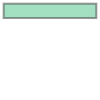

In [ ]:
item_shape

In [ ]:
item_col._data['assets']['image']['href']

'https://globalnightlight.s3.amazonaws.com/npp_201809/SVDNB_npp_d20180901_t0002302_e0008088_b35463_c20180901040811139620_nobc_ops.rade9.co.tif'

In [ ]:
gkids1809.iloc[0].vflag_href

'https://globalnightlight.s3.amazonaws.com/npp_201809/npp_d20180901_t0002302_e0008088_b35463.vflag.co.tif'

In [ ]:
# !curl -L -o ../data/ntlights-bigfiles/{gkids1809.iloc[0].vflag_file} {gkids1809.iloc[0].vflag_href}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4969k  100 4969k    0     0   613k      0  0:00:08  0:00:08 --:--:--  847k


In [ ]:
gkids180912 = gkids1809[gkids1809.start_date == '20180912'].copy()

In [ ]:
gkids180912.iloc[0].stem

'SVDNB_npp_d20180912_t0003271_e0009075_b35619_c20180912040907984373_nobc_ops'

In [ ]:
o = gkids180912.iloc[0]; o

href                                           ./SVDNB_npp_d20180912_t0003271_e0009075_b35619_c20180912040907984373_nobc_ops.rade9.co.json
item_href          https://globalnightlight.s3.amazonaws.com/npp_201809/SVDNB_npp_d20180912_t0003271_e0009075_b35619_c20180912040907984...
stem                                                           SVDNB_npp_d20180912_t0003271_e0009075_b35619_c20180912040907984373_nobc_ops
suffix                                                                                                                       rade9.co.json
base_url                                                                                         https://globalnightlight.s3.amazonaws.com
folder                                                                                                                          npp_201809
product_id                                                                                                                       SVDNB_npp
start_date                 

In [ ]:
type(o)

pandas.core.series.Series

In [ ]:
len(gkids180912)

128

In [ ]:
def get_item_data(item_link):
    item_col = Collection.open(item_link)
    item_shape = Polygon(item_col._data['geometry']['coordinates'][0])
    item_asset_href = item_col._data['assets']['image']['href']
    return (item_shape,item_asset_href)

In [ ]:
def extract_itemlink_components(df):
    (df['geometry'], 
     df['asset_href'] 
    ) = zip(*df['item_href'].map(get_item_data))
    return df

In [ ]:
%%time
# gkids180912 = extract_itemlink_components(gkids180912)

CPU times: user 3.82 s, sys: 127 ms, total: 3.95 s
Wall time: 2min 41s


In [ ]:
# gdf180912.to_file('../data/ntlights/gdf180912.geojson',driver='GeoJSON')
gdf180912 = gpd.read_file('../data/ntlights/gdf180912wgs84.geojson')

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# %%time
# ax = plt.axes()
# ax = gdf180912.plot(ax=ax, facecolor='none',edgecolor='blue')

In [ ]:
%%time
admin_areas = gpd.read_file('../data/admin_areas/phl_admbnda_adm3_psa_namria_20200529.shp')

CPU times: user 2.71 s, sys: 1.55 s, total: 4.27 s
Wall time: 4.27 s


In [ ]:
admin_areas.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
admin_areas.total_bounds

array([114.27789225,   4.5872945 , 126.6049656 ,  21.12188548])

In [ ]:
# %%time
# ph_admin_bbox = gpd.GeoDataFrame(data={'geometry':[box(*admin_areas.total_bounds)]},geometry='geometry',crs='EPSG:4326')

In [ ]:
# ph_admin_bbox.to_file('../data/admin_areas/ph_admin_bbox_wgs84.geojson',driver='GeoJSON')
ph_admin_bbox = gpd.read_file('../data/admin_areas/ph_admin_bbox_wgs84.geojson')

CPU times: user 197 ms, sys: 352 ms, total: 548 ms
Wall time: 129 ms


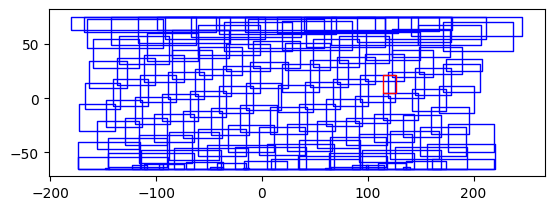

In [ ]:
%%time
ax = plt.axes()
ax = gdf180912.plot(ax=ax, facecolor='none',edgecolor='blue')
ax = ph_admin_bbox.plot(ax=ax,facecolor='none',edgecolor='red') 

In [ ]:
%%time
# phl_180912 = gdf180912.sjoin(ph_admin_bbox,how='inner',predicate='intersects')
# phl_180912.drop(columns=['index_right'],inplace=True)

CPU times: user 27.1 ms, sys: 0 ns, total: 27.1 ms
Wall time: 24.6 ms


In [ ]:
# phl_180912.to_file('../data/ntlights/phl180912wgs84.geojson', driver='GeoJSON')
phl_180912 = gpd.read_file('../data/ntlights/phl180912wgs84.geojson')

In [ ]:
len(phl_180912)

5

In [ ]:
phl_180912.asset_href

1507    https://globalnightlight.s3.amazonaws.com/npp_201809/SVDNB_npp_d20180912_t1622083_e1627487_b35629_c20180912202749189...
1508    https://globalnightlight.s3.amazonaws.com/npp_201809/SVDNB_npp_d20180912_t1627499_e1633303_b35629_c20180912203330273...
1509    https://globalnightlight.s3.amazonaws.com/npp_201809/SVDNB_npp_d20180912_t1633315_e1639102_b35629_c20180912203911323...
1516    https://globalnightlight.s3.amazonaws.com/npp_201809/SVDNB_npp_d20180912_t1804339_e1810125_b35630_c20180912221014499...
1517    https://globalnightlight.s3.amazonaws.com/npp_201809/SVDNB_npp_d20180912_t1810137_e1815541_b35630_c20180912221555548...
Name: asset_href, dtype: object

In [ ]:
phl_180912.iloc[0].asset_href

'https://globalnightlight.s3.amazonaws.com/npp_201809/SVDNB_npp_d20180912_t1622083_e1627487_b35629_c20180912202749189151_nobc_ops.rade9.co.tif'

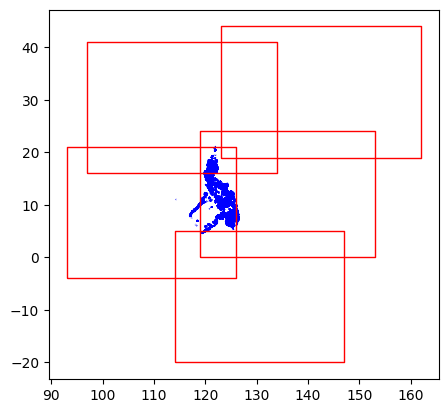

In [ ]:
ax = plt.axes()
ax = admin_areas.plot(ax=ax, facecolor='none', edgecolor='blue')
ax = phl_180912.plot(ax=ax, facecolor='none',edgecolor='red')

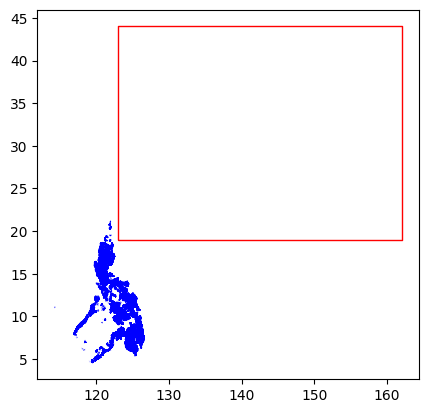

In [ ]:
ax = plt.axes()
ax = admin_areas.plot(ax=ax, facecolor='none', edgecolor='blue')
ax = phl_180912.iloc[0:1].plot(ax=ax, facecolor='none',edgecolor='red')

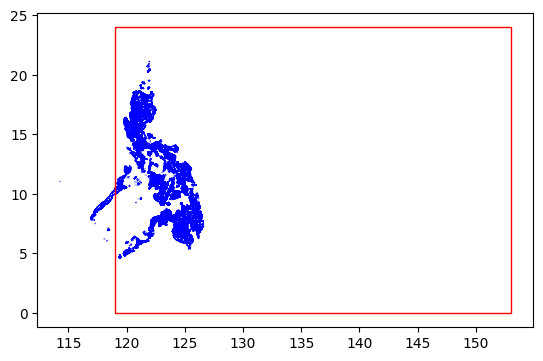

In [ ]:
ax = plt.axes()
ax = admin_areas.plot(ax=ax, facecolor='none', edgecolor='blue')
ax = phl_180912.iloc[1:2].plot(ax=ax, facecolor='none',edgecolor='red')

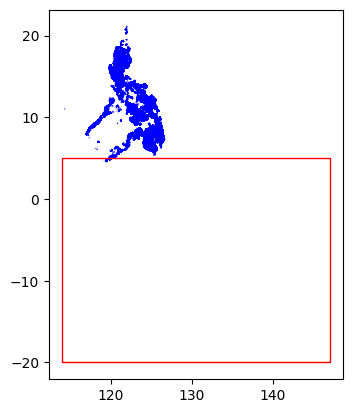

In [ ]:
ax = plt.axes()
ax = admin_areas.plot(ax=ax, facecolor='none', edgecolor='blue')
ax = phl_180912.iloc[2:3].plot(ax=ax, facecolor='none',edgecolor='red')

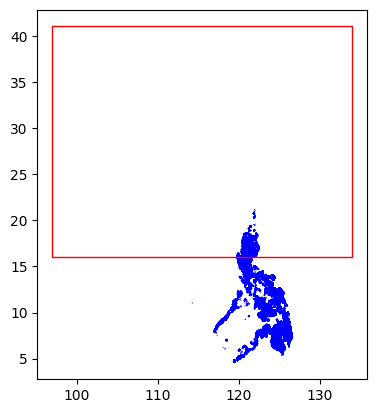

In [ ]:
ax = plt.axes()
ax = admin_areas.plot(ax=ax, facecolor='none', edgecolor='blue')
ax = phl_180912.iloc[3:4].plot(ax=ax, facecolor='none',edgecolor='red')

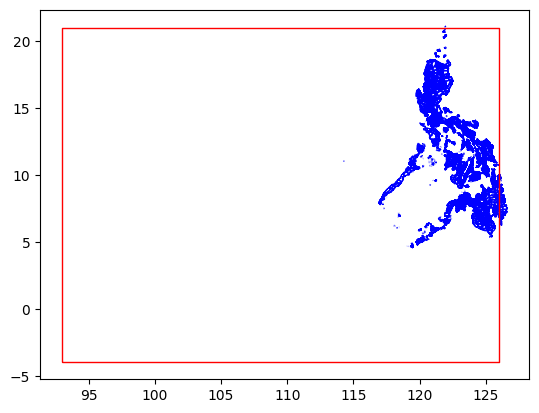

In [ ]:
ax = plt.axes()
ax = admin_areas.plot(ax=ax, facecolor='none', edgecolor='blue')
ax = phl_180912.iloc[4:5].plot(ax=ax, facecolor='none',edgecolor='red')

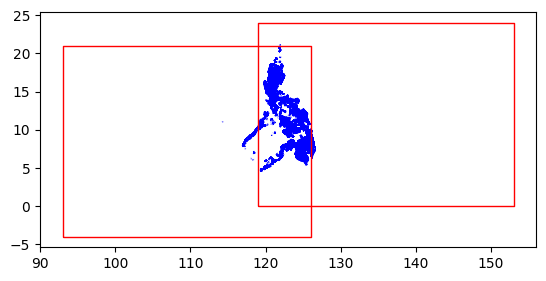

In [ ]:
ax = plt.axes()
ax = admin_areas.plot(ax=ax, facecolor='none', edgecolor='blue')
ax = phl_180912.iloc[[1,4]].plot(ax=ax, facecolor='none',edgecolor='red')

In [ ]:
# !curl -L -o ../data/ntlights-bigfiles/{phl_180912.iloc[1].stem}.rade9.co.tif {phl_180912.iloc[1].asset_href}

In [ ]:
# !curl -L -o ../data/ntlights-bigfiles/{phl_180912.iloc[4].stem}.rade9.co.tif {phl_180912.iloc[4].asset_href}

In [ ]:
!curl -L -o ../data/ntlights-bigfiles/{phl_180912.iloc[1].vflag_file} {phl_180912.iloc[1].vflag_href}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3171k  100 3171k    0     0   210k      0  0:00:15  0:00:15 --:--:--  280k


In [ ]:
!curl -L -o ../data/ntlights-bigfiles/{phl_180912.iloc[4].vflag_file} {phl_180912.iloc[4].vflag_href}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3299k  100 3299k    0     0   622k      0  0:00:05  0:00:05 --:--:--  714k


In [ ]:
admin_areas.total_bounds

array([114.27789225,   4.5872945 , 126.6049656 ,  21.12188548])

In [ ]:
import rasterio as rio

In [ ]:
# %%time
# with rio.open(phl_180912.iloc[1].asset_href) as src:
#     winblocks = list(src.block_windows())
#     # ij,window = random.choice(winblocks)
#     ij, window = winblocks[5*23+0]
#     # ij, window = winblocks[4*24+10]
#     # ij, window = winblocks[12*24+27]
#     arr = src.read(window=window)
#     nodata = src.nodata
#     crs = src.crs
#     bounds = src.bounds
# print(ij,window)
# plt.imshow(arr[0], cmap='seismic')
# plt.show()

In [ ]:
import numpy as np

In [ ]:
%%time
with rio.open(phl_180912.iloc[1].asset_href) as src:
    arr = src.read(1)
    crs = src.crs
    nodata1 = -999.3
    nodata2 = -1.5

CPU times: user 3.58 s, sys: 471 ms, total: 4.05 s
Wall time: 48.8 s


In [ ]:
arr.shape

(5760, 8160)

In [ ]:
np.min(arr)

-999.3

In [ ]:
len(arr[arr == nodata1])

13821981

In [ ]:
len(arr[arr < nodata2])

13821981

In [ ]:
arr[arr == nodata1] = np.NaN # replace nodata with np.nan

In [ ]:
np.nanmin(arr)

-1.5

In [ ]:
np.nanmax(arr)

93.1826

In [ ]:
import matplotlib.cm as cm

In [ ]:
import matplotlib as mpl

In [ ]:
cmap = cm.get_cmap('Greys').copy()
cmap.set_bad(color='blue')

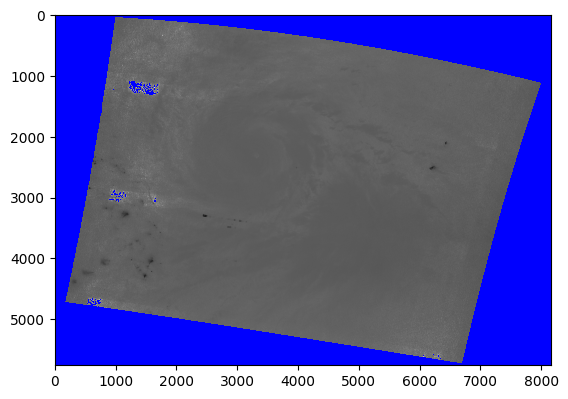

In [ ]:
plt.imshow(arr, norm=mpl.colors.LogNorm(vmin=-1.5, vmax=94.), cmap=cmap)
plt.show()

In [ ]:
%%time
with rio.open(phl_180912.iloc[4].asset_href) as src:
    arr = src.read(1)
    crs = src.crs
    nodata1 = -999.3
    nodata2 = -1.5

CPU times: user 3.56 s, sys: 370 ms, total: 3.94 s
Wall time: 1min 3s


In [ ]:
arr.shape

(6000, 7920)

In [ ]:
np.min(arr)

-999.3

In [ ]:
len(arr[arr == nodata1])

14673581

In [ ]:
len(arr[arr < nodata2])

14673581

In [ ]:
arr[arr == nodata1] = np.NaN # replace nodata with np.nan

In [ ]:
np.nanmin(arr)

-1.5

In [ ]:
np.nanmax(arr)

4206.6606

In [ ]:
# import matplotlib.cm as cm

In [ ]:
# import matplotlib as mpl

In [ ]:
cmap = cm.get_cmap('Greys').copy()
cmap.set_bad(color='blue')

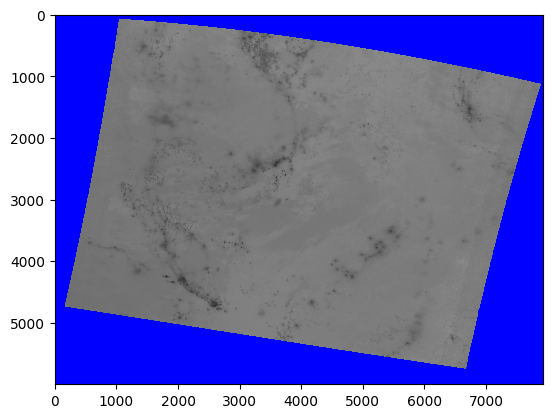

In [ ]:
plt.imshow(arr, norm=mpl.colors.LogNorm(vmin=-1.5, vmax=4206.), cmap=cmap)
plt.show()

### VFlag data

vflag.co.tif: a COG with a single band containing bitflags that can be queried for data quality

Data range: [0, 2^31-1]

“No-data” value: 2^31

Bit-fields: see Table 3

Data type: 32-bit integer

Units: Unitless

In [ ]:
%%time
with rio.open(phl_180912.iloc[4].vflag_href) as src:
    varr = src.read(1)
    nodata = src.nodata
    crs  = src.crs

CPU times: user 340 ms, sys: 71.8 ms, total: 412 ms
Wall time: 2.42 s


In [ ]:
nodata_mask = np.bitwise_and(varr, 2**31)

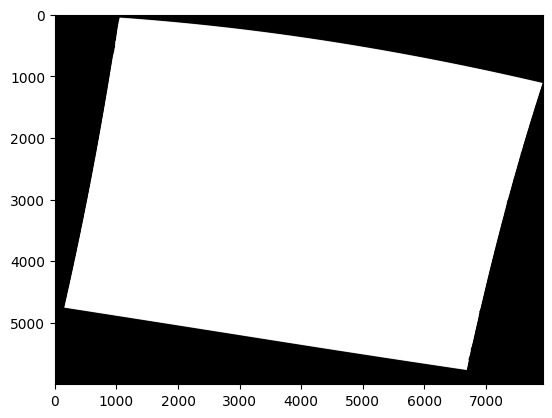

In [ ]:
plt.imshow(nodata_mask, cmap='Greys')
plt.show()

In [ ]:
bad_data_mask = np.bitwise_and(varr, 2**2)

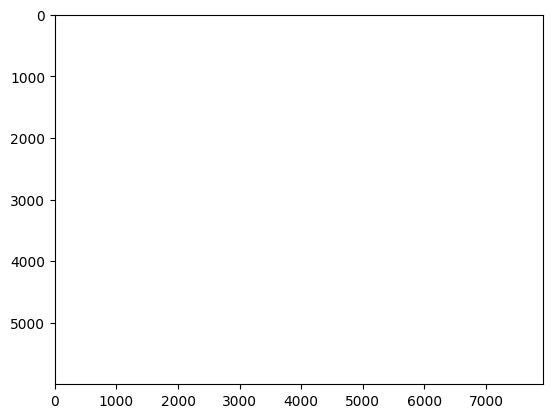

In [ ]:
plt.imshow(bad_data_mask, cmap='Greys')
plt.show()

In [ ]:
cloud_data_mask = np.bitwise_and(varr, 2**3 + 2**4)

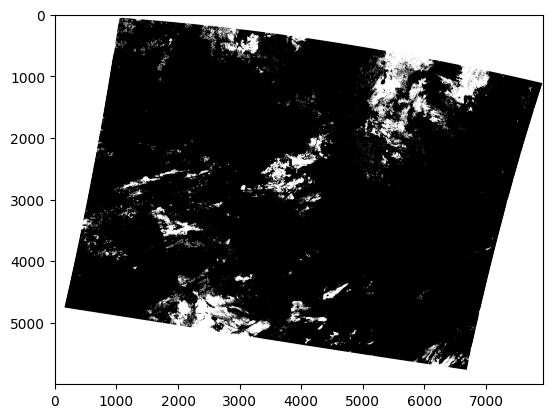

In [ ]:
plt.imshow(cloud_data_mask, cmap='Greys')
plt.show()

In [ ]:
from fastcore.all import *

In [ ]:
winblocks = L(winblocks)

In [ ]:
max(winblocks.itemgot(0).itemgot(1))

In [ ]:
max(winblocks.itemgot(0).itemgot(0))

In [ ]:
%%time
with rio.open(phl_180912.iloc[3].asset_href) as src:
    winblocks = list(src.block_windows())
    # ij,window = random.choice(winblocks)
    ij, window = winblocks[9*24+27]
    # ij, window = winblocks[4*24+10]
    # ij, window = winblocks[12*24+27]
    arr = src.read(window=window)
    nodata = src.nodata
    crs = src.crs
    bounds = src.bounds
print(ij,window)
plt.imshow(arr[0], cmap='seismic')
plt.show()

In [ ]:
%%time
src = rio.open(phl_180912.iloc[4].asset_href)

In [ ]:
winblocks = list(src.block_windows())

In [ ]:
ij,window = random.choice(winblocks)

In [ ]:
arr = src.read(window=window)

In [ ]:
nodata = src.nodata

In [ ]:
crs = src.crs

In [ ]:
bounds = src.bounds

In [ ]:
print(ij,window, bounds)

In [ ]:
plt.imshow(arr[0])
plt.show()

In [ ]:
src?

In [ ]:
src.close()

In [ ]:
# (9, 27) Window(col_off=6912, row_off=2304, width=256, height=256)
# (4, 10) Window(col_off=2560, row_off=1024, width=256, height=256)
# (12, 27) Window(col_off=6912, row_off=3072, width=256, height=256)
# (5, 15) Window(col_off=3840, row_off=1280, width=256, height=256) 

In [ ]:
bounds

In [ ]:
winblocks[0:5]

In [ ]:
len(winblocks)

In [ ]:
from fastcore.all import *

In [ ]:
winblocks = L(winblocks)

In [ ]:
max(winblocks.itemgot(0).itemgot(1))

In [ ]:
max(winblocks.itemgot(0).itemgot(0))

In [ ]:
# list(winblocks.itemgot(0))

In [ ]:
arr

In [ ]:
plt.imshow(arr[0])
plt.show()

In [ ]:
crs